In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# 그래프 한글 폰트
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

# 그래프 마이너스 폰트 깨지는 문제 대처
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False

import mglearn

# 그리드 서치
- 매개변수를 튜닝하여 일반화 성능 개선
    - 매개변수 조정 전, 해당 매개변수의  의미를 이해하는 것이 중요
- 관심있는 매개변수들을 대상으로 가능한 모든 조합을 시도해보는 것
    - 테이블..

## for문을 사용해 구현

In [2]:
# SVM - gamma, C
# 간단한 그리드 서치 구현
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.svm import SVC

iris = load_iris()

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)
print('훈련 세트의 크기: {},   테스트 세트의 크기: {}'.format(X_train.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # 매개변수 각 조합에 대해 SVC 훈련
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # 테스트 세트로 SVC 평가
        score = svm.score(X_test, y_test)
        # 점수가 best_score보다 더 높으면, 매개변수와 함께 기록
        if score > best_score:
            best_score = score
            best_parameters = {'C':C, 'gamma':gamma}

print('최고 점수: {:.2f}'.format(best_score))
print('최적 매개변수:', best_parameters)

훈련 세트의 크기: 112,   테스트 세트의 크기: 38
최고 점수: 0.97
최적 매개변수: {'C': 100, 'gamma': 0.001}


- 테스트 세트 정확도가 가장 높은 조합을 선택했다 할지라도, 이 정확도는 새로운 데이터에까지 이어지지 않을 수도..!
- 즉, 평가를 위해서는 모델을 만들 때(매개변수 조합 찾는 과정도 포함) 사용하지 않은 독립된 데이터셋 필요!

## train, validation, test set 3개 세트로 만들어 문제 해결
- train set: 모델 생성
- validation set: 모델의 매개변수 선택
- test set: 선택된 매개변수의 성능 평가
- 과정
    - 검증 세트를 사용해 최적의 매개변수를 선택한 후
    - **그 매개변수에서 훈련 세트와 검증 세트의 데이터를 모두 이용해 모델을 다시 만듬**
        - 모델을 만들 때 가능한 많은 데이터를 이용하기 위해서!
    - 그 후, test set을 이용해 최종 성능 평가

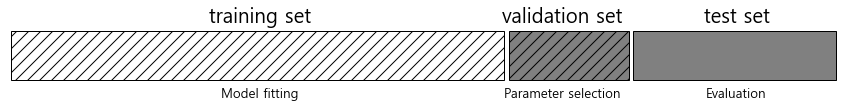

In [3]:
mglearn.plots.plot_threefold_split()

In [4]:
from sklearn.svm import SVC

# 데이터를 (train+valid) set, test set으로 분할
X_trainval, X_test, y_trainval, y_test = train_test_split(iris.data, iris.target, random_state=0)
#  (train+valid) set을 train set, vaild set으로 분할
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, random_state=1)

print('훈련 세트의 크기: {}, 검증 세트의 크기: {}, 테스트 세트의 크기: {}\n'.format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # 매개변수 각 조합에 대해 SVC 훈련
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # '검증(valid)' 세트로 SVC 평가!######
        score = svm.score(X_valid, y_valid)
        # 점수가 best_score보다 더 높으면, 매개변수와 함께 기록
        if score > best_score:
            best_score = score
            best_parameters = {'C':C, 'gamma':gamma}
            
# train set + valid set => 합쳐서 모델 다시 생성
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)   # (train+valid) set

# test set을 사용해 평가
test_score = svm.score(X_test, y_test)

print('검증 세트에서 최고 점수: {:.2f}'.format(best_score))
print('최적 매개변수:',best_parameters)
print('최적 매개변수에서 test set 점수: {:.2f}'.format(test_score))

훈련 세트의 크기: 84, 검증 세트의 크기: 28, 테스트 세트의 크기: 38

검증 세트에서 최고 점수: 0.96
최적 매개변수: {'C': 10, 'gamma': 0.001}
최적 매개변수에서 test set 점수: 0.92


- 검증 세트 최고 점수 96%로, 전보다 조금 낮아짐 <- 모델을 훈련할 때 사용한 데이터가 줄어들었기 때문
- 테스트 세트 점수는 더 낮은 96%로, 새로운 데이터에 대해 92%만 정확하게 분류한다고 할 수 있음

**훈련 세트, 검증 세트, 테스트 세트의 구분은 중요**
- 테스트 세트 정확도에 기초해 어떤 선택을 했다면, 테스트 세트의 정보를 모델에 누설한 것!(데이터 탐색을 위한 시각화 포함)
    - 따라서, 최종 평가에만 사용되도록 테스트 세트를 분리해 유지하는 것이 중요
- 모든 탐색적 분석과 모델 선택을 위해서는 훈련 세트와 검증 세트를 사용하는 것을 권장, 마지막 평가를 위해 테스트 세트 보관

## 교차 검증을 사용한 그리드 서치
- 일반화 성능을 더 잘 평가하려면, 훈련 세트와 검증 세트를 한번만 나누지 않고, 교차 검증을 사용해서, 각 매개변수의 조합의 성능을 평가해야함
    - 데이터 나누는 방법에 매우 민감하기 때문에, 처음 코드에서는 최적 매개변수가 {'C': 100, 'gamma': 0.001}, 이전 코드에서는 {'C': 10, 'gamma': 0.001}를 선택함

In [5]:
from sklearn.model_selection import cross_val_score

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # 매개변수 각 조합에 대해 SVC 훈련
        svm = SVC(gamma=gamma, C=C)
        # 교차 검증을 적용
        scores = cross_val_score(svm, X_trainval, y_trainval, cv=5)
        # 교차 검증 정확도의 평균을 계산
        score = np.mean(scores)
        # 점수가 best_score보다 더 높으면, 매개변수와 함께 기록
        if score > best_score:
            best_score = score
            best_parameters = {'C':C, 'gamma':gamma}
            
# train set + valid set => 합쳐서 모델 다시 생성
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)   # (train+valid) set

# test set을 사용해 평가
test_score = svm.score(X_test, y_test)

print('검증 세트에서 최고 점수: {:.2f}'.format(best_score))
print('최적 매개변수:',best_parameters)
print('최적 매개변수에서 test set 점수: {:.2f}'.format(test_score))

검증 세트에서 최고 점수: 0.97
최적 매개변수: {'C': 10, 'gamma': 0.1}
최적 매개변수에서 test set 점수: 0.97


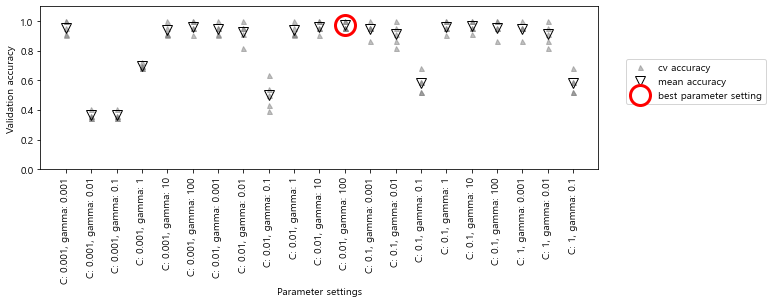

In [6]:
mglearn.plots.plot_cross_val_selection()

- 각 매개변수 설정마다 교차 검증 분할에 한 개씩, 모두 다섯개의 값을 계산

- 교차 검증은 어떤 데이터셋에 대해 주어진 알고리즘을 평가하는 방법임
- 하지만, **그리드 서치와 같은 매개변수 탐색 방법과 합쳐서 많이 사용함!**
    - 그래서 많은 사람들이 '교차 검증'이란 용어를 '교차 검증을 사용한 그리드 서치'라는 의미로 주로 사용함

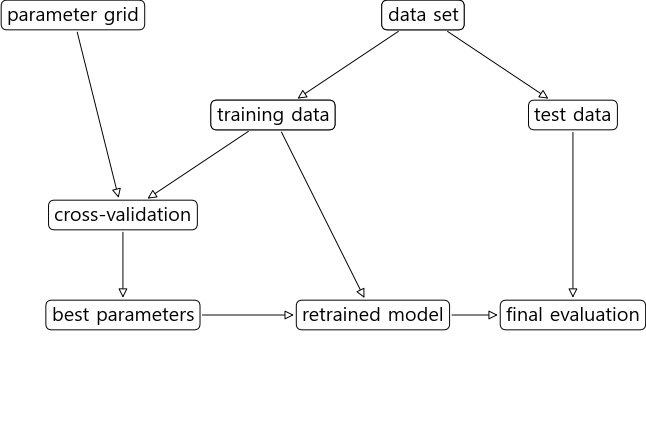

In [7]:
# 데이터를 나누고, 그리드 서치를 적용하여, 최종 매개변수를 평가하는 전체 과정
mglearn.plots.plot_grid_search_overview()

## GridSearchCV (교차 검증을 사용한 그리드 서치)
- **교차 검증을 사용한 그리드 서치**를 매개변수 조정 방법을 널리 사용하기 때문에, scikit-learn은 추정기 형태로 구현된 GridSearchCV를 제공함
- 교차 검증을 사용하지만, **매개 변수가 과적합 되는 것을 피하려면**, GridSearchCV에서도 데이터를 훈련 세트와 테스트 세트로 나눈 후, 적용해야함
    - GridSearchCV 사용 시 전달할 훈련 세트는 앞서 살펴본 훈련/검증/테스트 세트로 나눴을 대 훈련 세트와 검증 세트를 합친 trainval에 해당함 (GridSearchCV에서는 검증 세트가 겉으로 드러나지 않음)
- 딕셔너리 형태로 검색 대상 매개변수를 지정
    - 딕셔너리 key: 조정하고자 하는 매개변수 이름(모델 생성 시 지정할 것들, ex. C, gamma, ..)
    - 딕셔너리 value: 탐색할 매개변수의 설정값
- 그 후 GridSearchCV는 필요한 모든 모델을 학습 시킴
- GridSearchCV도 분류는 StratifiedKFold를, 회귀에서는 KFold를 기본값으로 사용
- 매개변수
    - 모델
    - 검색 대상 매개변수 그리드 (param_grid)
    - cv: 원하는 교차 검증 횟수 or 교차 분할기 객체
    - return_train_score: 훈련 폴드의 점수 포함 시키려면 True로 설정 (기본값 False)
    - n_jobs=-1 병렬화
- 메서드
    - fit
        - 최적의 매개변수를 찾음 + 교차 검증 성능이 가장 좋은 매개변수로 전체 train set에 대해 새로운 모델을 자동을 생성함!
    - predict
    - score
        - 찾은 최적 매개변수로 일반화 성능을 평가하려면, test set을 매개변수로 넘겨 score메서드 호출하면됨
- 속성
    - best_params_: 최적의 매개변수
    - best_score_: 최상의 교차 검증 정확도 
        - 매개변수 설정으로 각 분할에서 얻은 정확도의 평균
        - 훈련 세트에서 수행한 교차 검증의 평균 정확도 저장됨
    - best_estimator: 최적의 매개변수로 전체 train set을 사용하여, 학습/생성한 모델
        - 실제 모델에 직접 접근해 **계수, 특성 중요도** 등을 살펴보려고 할 때 사용됨
        - grid_search 객체가 predict와 score 메서드를 가지고 있으므로, 예측이나 모델 평가를 위해 best_estimator_ 속성을 사용할 필요는 없음
    - cv_results_: 그리스 서치 결과와 관련된 여러 정보가 함께 저장되어있음 (dataframe으로 변환해서 보는 것이 좋음)

### RandomizedSearchCV
- 주어진 범위에서 매개변수를 무작위로 선택하여 조사함
- 결과가 GridSearchCV보다 크게 뒤지지 않고, 검색이 빠름
    - 매개변수의 조합이 매우 많거나 규제 매개변수와 같이 연속형 값을 조정해야 할 때 널리 사용함
- n_jter
    - 매개변수 샘플링 횟수 (기본값 10)

In [8]:
# 검색 대상 매개변수 설정
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
             'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

print('매개변수 그리드:\n', param_grid)

매개변수 그리드:
 {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}


In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# GridSearchCV 객체 생성
grid_search = GridSearchCV(SVC(), param_grid, cv=5, return_train_score=True)  # 5번의 교차 검증 사용

In [10]:
# 매개 변수가 과적합 되는 것을 피하려면, GridSearchCV에서도 데이터를 훈련 세트와 테스트 세트로 나눈 후, 적용해야함
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)

In [11]:
# fit - 최적의 매개변수 찾음 + 교차 검증 선능이 가장 좋은 매개변수로 전체 train set에 대해 새로운 모델을 자동으로 생성함
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
             return_train_score=True)

In [12]:
print('최적 매개변수:', grid_search.best_params_)
print('최고 교차 검증 정수: {:.2f}'.format(grid_search.best_score_))

최적 매개변수: {'C': 10, 'gamma': 0.1}
최고 교차 검증 정수: 0.97


In [13]:
print('테스트 세트 점수: {:.2f}'.format(grid_search.score(X_test, y_test)))

테스트 세트 점수: 0.97


In [14]:
# 실제 모델에 직접 접근해 계수, 특성 중요도 등을 살펴보려고 할 때 사용
# grid_search 객체가 predict와 score 메서드를 가지고 있으므로, 예측이나 모델 평가를 위해 best_estimator_ 속성을 사용할 필요는 없음
print('최고 성능 모델:\n', grid_search.best_estimator_)

최고 성능 모델:
 SVC(C=10, gamma=0.1)


In [16]:
# 결과 관련 정보 조회 - cv_results_
import pandas as pd
pd.set_option('display.max_columns', None)
# DataFrame으로 변환
result = pd.DataFrame(grid_search.cv_results_)
# 처음 5개 행 출력
np.transpose(result.head())  # result.head().T

,0,1,2,3,4
mean_fit_time,0.00219569,0.00118766,0.00120296,0.00100503,0.000999975
std_fit_time,0.000404433,0.000375469,0.00041347,1.3178e-05,5.0179e-06
mean_score_time,0.00120139,0.000398111,0.000791025,0.000603724,0.000596046
std_score_time,0.000396661,0.000487586,0.000395725,0.000493119,0.000486688
param_C,0.001,0.001,0.001,0.001,0.001
param_gamma,0.001,0.01,0.1,1,10
params,"{'C': 0.001, 'gamma': 0.001}","{'C': 0.001, 'gamma': 0.01}","{'C': 0.001, 'gamma': 0.1}","{'C': 0.001, 'gamma': 1}","{'C': 0.001, 'gamma': 10}"
split0_test_score,0.347826,0.347826,0.347826,0.347826,0.347826
split1_test_score,0.347826,0.347826,0.347826,0.347826,0.347826
split2_test_score,0.363636,0.363636,0.363636,0.363636,0.363636


- results의 행 하나는 특정한 하나의 매개변수 설정에 대응함
- 각 설정에 대해 교차 검증의 모든 분할의 평균값, 표준편차를 포함한 결과가 기록되어있음
- 검색 대상 매개변수 그리드가 2차원 이므로(C와 gamma), 히트 맵으로 시각화하기 좋음

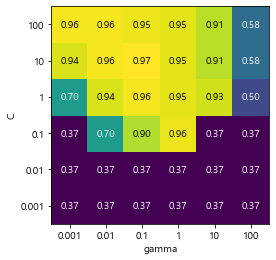

In [21]:
# 교차 검증의 평균을 뽑아서, C와 gamma 축에 맞도록 배열 차원 바꾸기 (C가 행/y축, gamma가 열/x축 방향으로)
scores = np.array(result.mean_test_score).reshape(6,6)

# 교차 검증 평균 점수 히트맵 그래프
mglearn.tools.heatmap(scores, xlabel='gamma', xticklabels=param_grid['gamma'], 
                              ylabel='C', yticklabels=param_grid['C'], cmap='viridis')

- 매개변수 설정에따라 정확도가 40% ~ 96%까지 차이가나, SCV가 매개변수 걸정에 매우 민감함을 알 수 있음
- 높은 성능을 얻으려면 매개변수 조정이 매우 중요
- 선택한 매개변수 그리드의 범위에서 결괏값이 크게 변하고 있음
    - 즉, 각 매개변수 최적값이 그래프 끝에 놓이지 않도록 매개변수의 범위가 충분히 넓음! <- 주의!

In [27]:
# # 검색 범위가 적절하게 선택되지 않아서, 바람직하지 못한 결과 내는 히트맵 예시
# fig, axes = plt.subplots(1, 3, figsize=(13,5))

# param_grid_linear = {'C':np.linspace(1,2,6),
#                     'gamma': np.linspace(1,2,6)}

# param_grid_one_log = {'C':np.linspace(1,2,6),
#                     'gamma': np.linspace(-3,2,6)}

# param_grid_range = {'C':np.linspace(-3,2,6),
#                     'gamma': np.linspace(-7,-2,6)}

# for param_grid, ax in zip([param_grid_linear, param_grid_one_log, param_grid_range], axes):
#     grid_search = GridSearchCV(SVC(), param_grid, cv=5)
#     grid_search.fit(X_train, y_train)
#     scores = grid_search.cv_results_['mean_test_score'].reshape(6,6)
    
#     # 교차 검증 평균 점수의 히트맵 그래프
#     scores_image = mglearn.tools.heatmap(scores, xlabel='gamma',ylabel='C', 
#                                          xticklabels=param_grid['gamma'], yticklabels=param_grid['C'], cmap='viridis', ax=ax)
# plt.colorbar(scores_image, ax=axes.tolist())

- 책 이미지 참고 5-9

## 비대칭 매개변수 그리드 탐색 - 조건부 매개변수 조합
- 경우에 따라 **모든 매개변수의 조합**에 대해 GridSearchCV를 수행하는 것이 **시간낭비**일 수도
    - ex. SVC의 kernel 매개변수에 따른 C, gamma 사용/미사용 여부 달라짐
        - kernel='linear' => C 매개변수만 사용
        - kernel='rbf' => C, gamma 모두 사용
        - kernel='degree' => C, gamma 모두 사용 않함
    - 따라서 모든 매개변수의 모든 조합을 조사하는 것은 맞지 않음
- 조건부 매개변수 조합 적용
    - GridSearchCV에 전달할 param_grid를 딕셔너리의 리스트로 만들어주면됨
    - 각 딕셔너리는 독립적인 grid로 적용됨

In [28]:
# param_grid 조건부 매개변수 조합 
param_grid = [{'kernel':['rbf'],
              'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma':[0.001, 0.01, 0.1, 1, 10, 100]},
             {'kernel':['linear'],
             'C':[0.001, 0.01, 0.1, 1, 10, 100]}]
print('그리드 목록:\n', param_grid)

그리드 목록:
 [{'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}, {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]


In [29]:
# 적용
grid_search = GridSearchCV(SVC(), param_grid, cv=5, return_train_score=True)
grid_search.fit(X_train, y_train)
print('최적 파라미터:', grid_search.best_params_)
print('최고 교차 검증 점수: {:.2f}'.format(grid_search.best_score_))

최적 파라미터: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
최고 교차 검증 점수: 0.97


In [30]:
# cv_results_
results = pd.DataFrame(grid_search.cv_results_)
results.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41
mean_fit_time,0.00139666,0.00159574,0.00159607,0.000797987,0.000996637,0.000598574,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00312424,0,0,0.00312109,0,0.00312581,0,0,0,0,0,0,0,0.0031251
std_fit_time,0.000488325,0.000488034,0.000490742,0.000398994,0.00063023,0.000797999,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00624847,0,0,0.00624218,0,0.00625162,0,0,0,0,0,0,0,0.00625019
mean_score_time,0.00099678,0.000798035,0.00101213,0.00059824,0.000597382,0.000285673,0,0.00312438,0,0,0,0,0,0,0,0,0,0.00312376,0.0031239,0,0,0,0.0031251,0,0,0,0,0,0,0,0.00312572,0,0,0,0,0,0,0,0,0,0,0
std_score_time,1.21944e-06,0.000399018,0.000640286,0.000488461,0.000487761,0.000571346,0,0.00624876,0,0,0,0,0,0,0,0,0,0.00624752,0.00624781,0,0,0,0.00625019,0,0,0,0,0,0,0,0.00625143,0,0,0,0,0,0,0,0,0,0,0
param_C,0.001,0.001,0.001,0.001,0.001,0.001,0.01,0.01,0.01,0.01,0.01,0.01,0.1,0.1,0.1,0.1,0.1,0.1,1,1,1,1,1,1,10,10,10,10,10,10,100,100,100,100,100,100,0.001,0.01,0.1,1,10,100
param_gamma,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,10,100,NaN,NaN,NaN,NaN,NaN,NaN
param_kernel,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,linear,linear,linear,linear,linear,linear
params,"{'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 10, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 10, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.1, 'gamma': 10, 'kernel': 'rbf'}","{'C': 0.1, 'gamma': 100, 'kernel': 'rbf'}","{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 1, 'gamma': 1, 'kernel': 'rbf'}","{'C': 1, 'gamma': 10, 'kernel': 'rbf'}","{'C': 1, 'gamma': 100, 'kernel': 'rbf'}","{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 10, 'gamma': 1, 'kernel': 'rbf'}","{'C': 10, 'gamma': 10, 'kernel': 'rbf'}","{'C': 10, 'gamma': 100, 'kernel': 'rbf'}","{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 10, 'kernel': 'rbf'}","{'C': 100, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.001, 'kernel': 'linear'}","{'C': 0.01, 'kernel': 'linear'}","{'C': 0.1, 'kernel': 'linear'}","{'C': 1, 'kernel': 'linear'}","{'C': 10, 'kernel': 'linear'}","{'C': 100, 'kernel': 'linear'}"
split0_test_score,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.695652,0.913043,1,0.347826,0.347826,0.695652,0.913043,1,0.956522,0.913043,0.391304,0.913043,1,1,0.956522,0.869565,0.521739,1,1,1,0.956522,0.869565,0.521739,0.347826,0.869565,1,1,1,0.956522
split1_test_score,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.695652,0.913043,0.913043,0.347826,0.347826,0.695652,0.913043,0.956522,0.913043,0.956522,0.434783,0.913043,0.956522,0.956522,0.956522,0.913043,0.521739,0.956522,0.913043,0.956522,0.956522,0.913043,0.521739,0.347826,0.869565,0.913043,0.956522,1,0.956522


- kernel이 linear일 땐 C만 변경되며, gamma값은 NaN

## GridSearchCV에 다양한 교차 검증 적용
- GridSearchCV는 기본적으로 분류에 계층형 k-겹 교차검증, 회귀에는 k-겹 교차 검증 사용
- cv 매개변수를 통해 다른 교차 검증 분할기 사용 가능
- 데이터셋이 매우 크거나 모델 구축 시간이 오래걸릴 경우
    - 특별히 훈련 세트와 검증 세트로 한 번만 분할하게 n_splits=1로 하고, ShuffleSplit or StratifiedShuffleSplit을 사용하면 유용

## 중첩 교차 검증 -  just 일반화 확인용
- 훈련 세트와 테스트 세트로 나눈 다음, 훈련 세트로 교차 검증을 수행하는 GridSearchCV
    - 훈련 세트와 테스트 세트로 한번만 나누기 때문에, 결과가 불안정하고 테스트 데이터의 분할에 크게 의존함
- 더 나아가 교차 검증 분할 방식 사용한 중첩 교차 검증
    - 모델이나 매개변수 설정이 아닌, 테스트 점수의 목록을 만들어 줌
    - 그리드 서치를 통해 찾은 최적 매개변수가 모델을 얼마나 잘 일반화 시키는지 알려줌
    - 새로운 데이터에 적용할 모델을 만드는 것이 아님!
        - 중첩 교차 검증은 미래의 데이터에 적용하기 위한 예측 모델을 찾는데 사용하지 않음
    - 특정 데이터셋에서 주어진 모델이 얼마나 잘 일반화 되는지 평가하는 데 유용한 방법
- GridSearchCV의 객체를 모델로 삼아 cross_val_score 함수를 호출하면됨
    - cross_val_score가 바깥쪽 루프를 의미하며, GridSearchCV가 안쪽 루프 역할을 함
    - 두 함수 각각의 cv 매개변수에 각기 다른 교차 검증 분할기를 사용할 수 있음
    - 두 함수 모두에 n_jobs=-1 병렬화 가능

In [33]:
# from sklearn.model_selection import cross_val_score
param_grid = {'C':[0.001, 0.01, 0.1, 1, 10, 100],
             'gamma':[0.001, 0.01, 0.1, 1, 10, 100]}
# 두 함수 모두에 n_jobs=-1 병렬화 가능
scores = cross_val_score(GridSearchCV(SVC(), param_grid, cv=5, n_jobs=-1), iris.data, iris.target, cv=5, n_jobs=-1)

print('교차 검증 점수: ', scores)
print('교차 검증 평균 점수: ', scores.mean())

교차 검증 점수:  [0.96666667 1.         0.96666667 0.96666667 1.        ]
교차 검증 평균 점수:  0.9800000000000001


- 중첩 교차 검증의 결과를 요약하면, 'SVC는 iris data set에서 평균 교차 검증 정확도가 98%다' 이며, 그 이상도 이하도 아님